In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats, signal

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/tests")
sys.path.append("../src/bout")

In [3]:
import bout.assembly as bt
import activity.activity_assembly as actvt
import activity.subsampling as ss

import comparison.plot as complot

In [4]:
def are_there_expected_number_of_cycles(location_df, first_call_of_each_group, cycle_length, data_params):
    first_date = pd.to_datetime(location_df['call_start_time']).iloc[0].date()
    last_date = (pd.to_datetime(location_df['call_start_time'])).iloc[-1].date()
    first_dt = dt.datetime.combine(first_date, pd.to_datetime(data_params['recording_start'], format="%H:%M").time())
    last_dt = dt.datetime.combine(last_date, pd.to_datetime(data_params['recording_end'], format="%H:%M").time())

    all_cycles = pd.date_range(first_dt, last_dt, freq=f'{cycle_length}T')
    between_time_cycles = all_cycles[(all_cycles.indexer_between_time(data_params['recording_start'], data_params['recording_end']))]
    
    assert first_call_of_each_group.shape[0] <= between_time_cycles.shape[0]

In [5]:
def all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs):
    resampled_cycle_length_df = dc_applied_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    last_call_of_each_group = resampled_cycle_length_df.last()
    assert last_call_of_each_group['end_time_wrt_ref'].all() < time_on_in_secs

In [6]:
def simulate_dutycycle_on_detections(location_df, cycle_length, time_on_in_secs, data_params):
    """
    Simulates a provided duty-cycling scheme on the provided location summary of concatenated bd2 outputs.
    """ 

    location_df = assign_cycle_groups_to_each_call(location_df, cycle_length, data_params)
    dc_applied_df = gather_calls_existing_in_on_windows(location_df, time_on_in_secs)
    if not(dc_applied_df.empty):
        all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs)

    return dc_applied_df

def gather_calls_existing_in_on_windows(location_df, time_on_in_secs):

    location_df.insert(0, 'end_time_wrt_ref', (location_df['call_end_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    location_df.insert(0, 'start_time_wrt_ref', (location_df['call_start_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    dc_applied_df = location_df.loc[(location_df['end_time_wrt_ref'] <= time_on_in_secs)&(location_df['start_time_wrt_ref'] >= 0)].copy()

    return dc_applied_df

def assign_cycle_groups_to_each_call(location_df, cycle_length, data_params):
    location_df['ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['cycle_ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['call_end_time'] = pd.DatetimeIndex(location_df['call_end_time'])
    location_df['call_start_time'] = pd.DatetimeIndex(location_df['call_start_time'])

    resampled_cycle_length_df = location_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    first_call_of_each_group = resampled_cycle_length_df.first().between_time(data_params['recording_start'], data_params['recording_end'])
    are_there_expected_number_of_cycles(location_df, first_call_of_each_group, cycle_length, data_params)
    location_df['cycle_ref_time'] = pd.DatetimeIndex(resampled_cycle_length_df['cycle_ref_time'].transform(lambda x: x.name))

    return location_df

In [7]:
def get_activity_index_per_cycle(location_df, cycle_length, index):
    """
    Constructs a pandas Series that records the activity index observed per interval.
    The used interval is the one stored inside data_params['bin_size']
    The activity index time block is stored inside data_params['index_time_block_in_secs']
    """

    location_df['ref_time'] = location_df['call_start_time']
    temp = location_df.resample(f'{index}S', on='ref_time')['ref_time'].count()
    temp[temp>0] = 1
    activity_indices = temp.resample(f"{cycle_length}T").sum()
    
    return activity_indices

def get_activity_index_per_time_on_index(num_blocks_presence, time_on, index_time_block):
    return num_blocks_presence / (time_on / index_time_block)

In [8]:
def create_initial_mock_data_from_ipis(ipis):
    """
    Created a simulated dataset of calls for a period of 30-min where the provided IPIs are used to separate each call.
    """

    mock_df = pd.DataFrame(columns=['ref_time', 'call_start_time', 'call_end_time', 'start_time', 'end_time', 'low_freq', 'high_freq', 'freq_group', 'class'])
    recording_start = dt.datetime(2022, 6, 15, 1, 00, 0)
    recording_end = recording_start+dt.timedelta(minutes=30)
    call_duration = 0.01
    for i in range(0, len(ipis)):
        start_time = ipis[:i+1].cumsum(axis=0)[-1]+ i*call_duration
        call_start_time = recording_start + dt.timedelta(seconds=start_time)
        call_end_time = recording_start + dt.timedelta(seconds=start_time+call_duration)
        ref_time = pd.to_datetime(call_start_time).floor('30T')
        if (call_end_time <= recording_end):
            mock_df.loc[i] = [ref_time, call_start_time, call_end_time, start_time, start_time+call_duration, 20000, 30000, 'LF', 'simulation']

    return mock_df

def test_num_dets_metric_using_simulated_dataset():
    """
    Create a simulated dataset of calls with 5 bouts of calls where within-bout calls are separated by IPI of 90ms.
    Bouts are separated by intervals of 5-min. 
    The BCI is set to be 150ms so we test the bout clustering functions to see if we get 5 bouts exactly.

    The number of detections should be equal to the number of IPIs (including the IPI required before the first call)
    The activity index should be equal to the number of bouts because each bout falls completely within just a single time block.
    The measured bout duration should be equal to the derived bout duration.
    Bout duration derived by calculating the duration of 10 calls and 9 IPIs per bout.
    """

    points = 50
    t = np.linspace(0, 1, points, endpoint=False)

    A = 150
    mock_square_ipis = A*(signal.square(2 * np.pi * 5 * t, 1/points) + 1)
    call_duration = 0.01
    desired_ipi = 0.09

    mock_square_ipis[mock_square_ipis==0] = desired_ipi
    mock_bout_df = create_initial_mock_data_from_ipis(mock_square_ipis)

    data_params = dict()
    data_params['resolution_in_min'] = '30'
    data_params["index_time_block_in_secs"] = '5'
    data_params['recording_start'] = '00:00'
    data_params['recording_end'] = '16:00'
    data_params['cur_dc_tag'] = '30of30'
    data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
    data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
    data_params['time_on_in_secs'] = 60*data_params['time_on']

    mock_bout_df = simulate_dutycycle_on_detections(mock_bout_df, data_params['cycle_length'], data_params['time_on_in_secs'], data_params)
    bout_params = dict()
    bout_params['LF1_bci'] = 150
    tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(mock_bout_df, bout_params)
    
    test_preds = tagged_dets.copy()
    assert(get_activity_index_per_cycle(test_preds, data_params['cycle_length'], data_params["index_time_block_in_secs"]).sum() == points)

In [9]:
def repeat_init_30_min_mock_to_date_range(mock_df, periods):
    sum_df = mock_df.copy()
    df_to_concatenate = mock_df.copy()

    for i in range(len(periods)):
        for col in df_to_concatenate.columns:
            if type(df_to_concatenate[col].values[0]) == np.datetime64:
                df_to_concatenate[col] = df_to_concatenate[col] + pd.Timedelta(minutes=30)
        sum_df = pd.concat([sum_df, df_to_concatenate])

    return sum_df

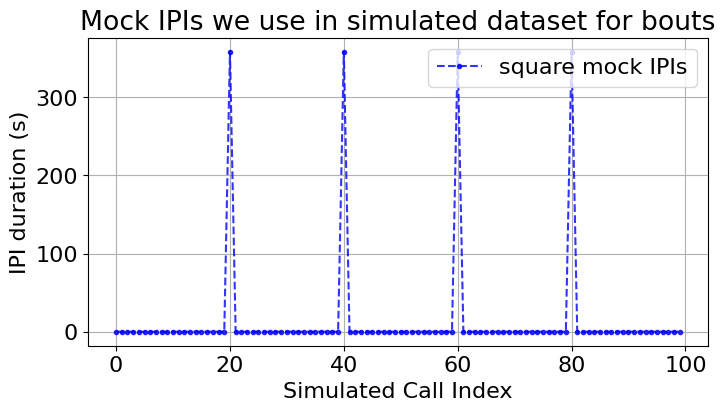

In [10]:
desired_num_bouts = 5
calls_per_bout = 20
points = calls_per_bout*desired_num_bouts
t = np.linspace(0, 1, points, endpoint=False)

call_duration = 0.01
desired_ipi = 0.09
bout_break_time = (1800/desired_num_bouts) - ((calls_per_bout*call_duration)+((calls_per_bout-1)*desired_ipi))
A = bout_break_time/2
mock_square_ipis = A*(signal.square(2 * np.pi * desired_num_bouts * t, duty=1/points) + 1)
mock_square_ipis[0] = desired_ipi
mock_square_ipis[mock_square_ipis==0] = desired_ipi

plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size':16})
plt.title('Mock IPIs we use in simulated dataset for bouts')
plt.plot(mock_square_ipis, color='blue', marker='.', alpha=0.8, linestyle='dashed', label='square mock IPIs')
plt.grid(which='both')
plt.ylabel('IPI duration (s)')
plt.xlabel('Simulated Call Index')
plt.legend(loc='upper right')
plt.show()

In [11]:
mock_df = create_initial_mock_data_from_ipis(mock_square_ipis)
mock_df[:51]

,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,freq_group,class
0,2022-06-15 01:00:00,2022-06-15 01:00:00.090,2022-06-15 01:00:00.100,0.09,0.1,20000,30000,LF,simulation
1,2022-06-15 01:00:00,2022-06-15 01:00:00.190,2022-06-15 01:00:00.200,0.19,0.2,20000,30000,LF,simulation
2,2022-06-15 01:00:00,2022-06-15 01:00:00.290,2022-06-15 01:00:00.300,0.29,0.3,20000,30000,LF,simulation
3,2022-06-15 01:00:00,2022-06-15 01:00:00.390,2022-06-15 01:00:00.400,0.39,0.4,20000,30000,LF,simulation
4,2022-06-15 01:00:00,2022-06-15 01:00:00.490,2022-06-15 01:00:00.500,0.49,0.5,20000,30000,LF,simulation
5,2022-06-15 01:00:00,2022-06-15 01:00:00.590,2022-06-15 01:00:00.600,0.59,0.6,20000,30000,LF,simulation
6,2022-06-15 01:00:00,2022-06-15 01:00:00.690,2022-06-15 01:00:00.700,0.69,0.7,20000,30000,LF,simulation
7,2022-06-15 01:00:00,2022-06-15 01:00:00.790,2022-06-15 01:00:00.800,0.79,0.8,20000,30000,LF,simulation
8,2022-06-15 01:00:00,2022-06-15 01:00:00.890,2022-06-15 01:00:00.900,0.89,0.9,20000,30000,LF,simulation
9,2022-06-15 01:00:00,2022-06-15 01:00:00.990,2022-06-15 01:00:01.000,0.99,1.0,20000,30000,LF,simulation


In [12]:
periods = pd.date_range(dt.datetime(2022,6,15,1,30,0), dt.datetime(2022,6,15,16,0,0),freq='30T', inclusive='left')
sum_df = repeat_init_30_min_mock_to_date_range(mock_df, periods)

In [13]:
sum_df

,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,freq_group,class
0,2022-06-15 01:00:00,2022-06-15 01:00:00.090,2022-06-15 01:00:00.100,0.09,0.1,20000,30000,LF,simulation
1,2022-06-15 01:00:00,2022-06-15 01:00:00.190,2022-06-15 01:00:00.200,0.19,0.2,20000,30000,LF,simulation
2,2022-06-15 01:00:00,2022-06-15 01:00:00.290,2022-06-15 01:00:00.300,0.29,0.3,20000,30000,LF,simulation
3,2022-06-15 01:00:00,2022-06-15 01:00:00.390,2022-06-15 01:00:00.400,0.39,0.4,20000,30000,LF,simulation
4,2022-06-15 01:00:00,2022-06-15 01:00:00.490,2022-06-15 01:00:00.500,0.49,0.5,20000,30000,LF,simulation
...,...,...,...,...,...,...,...,...,...
95,2022-06-15 15:30:00,2022-06-15 15:54:01.590,2022-06-15 15:54:01.600,1441.59,1441.6,20000,30000,LF,simulation
96,2022-06-15 15:30:00,2022-06-15 15:54:01.690,2022-06-15 15:54:01.700,1441.69,1441.7,20000,30000,LF,simulation
97,2022-06-15 15:30:00,2022-06-15 15:54:01.790,2022-06-15 15:54:01.800,1441.79,1441.8,20000,30000,LF,simulation
98,2022-06-15 15:30:00,2022-06-15 15:54:01.890,2022-06-15 15:54:01.900,1441.89,1441.9,20000,30000,LF,simulation


In [14]:
data_params = dict()
data_params['resolution_in_min'] = '30'
data_params["index_time_block_in_secs"] = 5
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '6of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']

cont_sum_df = simulate_dutycycle_on_detections(sum_df.copy(), data_params['cycle_length'], data_params['time_on_in_secs'], data_params)
cont_act_inds = get_activity_index_per_cycle(cont_sum_df, data_params['cycle_length'], data_params["index_time_block_in_secs"])

In [15]:
cont_act_ind_p = get_activity_index_per_time_on_index(cont_act_inds, 60*data_params['cycle_length'], data_params["index_time_block_in_secs"])
cont_act_ind_p

ref_time
2022-06-15 01:00:00    0.013889
2022-06-15 01:06:00    0.013889
2022-06-15 01:12:00    0.013889
2022-06-15 01:18:00    0.013889
2022-06-15 01:24:00    0.013889
                         ...   
2022-06-15 15:30:00    0.013889
2022-06-15 15:36:00    0.013889
2022-06-15 15:42:00    0.013889
2022-06-15 15:48:00    0.013889
2022-06-15 15:54:00    0.013889
Freq: 6T, Name: ref_time, Length: 150, dtype: float64

In [16]:
data_params = dict()
data_params['resolution_in_min'] = '30'
data_params["index_time_block_in_secs"] = 5
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '1of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']

dc_applied_df1 = simulate_dutycycle_on_detections(sum_df.copy(), data_params['cycle_length'], data_params['time_on_in_secs'], data_params)
dc_act_inds1 = get_activity_index_per_cycle(dc_applied_df1, data_params['cycle_length'], data_params["index_time_block_in_secs"])

In [17]:
dc_act_inds_p1 = get_activity_index_per_time_on_index(dc_act_inds1, data_params['time_on_in_secs'], data_params["index_time_block_in_secs"])
dc_act_inds_p1

ref_time
2022-06-15 01:00:00    0.083333
2022-06-15 01:06:00    0.083333
2022-06-15 01:12:00    0.083333
2022-06-15 01:18:00    0.083333
2022-06-15 01:24:00    0.083333
                         ...   
2022-06-15 15:30:00    0.083333
2022-06-15 15:36:00    0.083333
2022-06-15 15:42:00    0.083333
2022-06-15 15:48:00    0.083333
2022-06-15 15:54:00    0.083333
Freq: 6T, Name: ref_time, Length: 150, dtype: float64

In [26]:
assert (6*cont_act_ind_p == dc_act_inds_p1).all()

/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


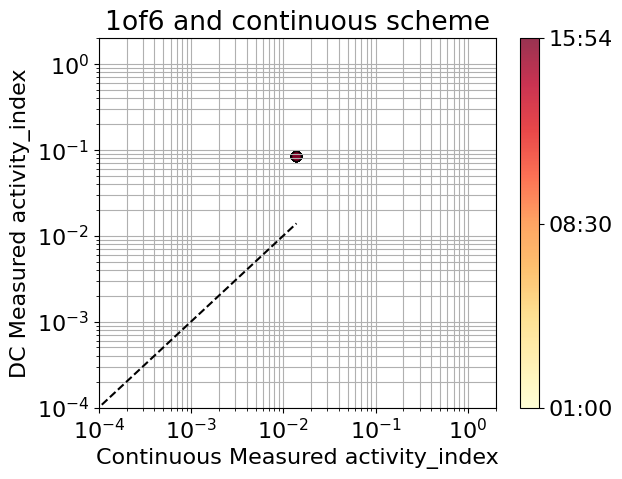

In [19]:
data_params['metric_tag'] = 'activity_index'
cont_act_ind_col = actvt.filter_and_prepare_metric(cont_act_ind_p, data_params)
cont_act_ind_col.set_index('datetime_UTC', inplace=True)

dc_act_ind_col1 = actvt.filter_and_prepare_metric(dc_act_inds_p1, data_params)
dc_act_ind_col1.set_index('datetime_UTC', inplace=True)
complot.plot_indiv_dc_control_comp_over_cycle(dc_act_ind_col1, cont_act_ind_col, data_params)

In [20]:
data_params = dict()
data_params['resolution_in_min'] = '30'
data_params["index_time_block_in_secs"] = 5
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '6of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']

cont_sum_df2 = simulate_dutycycle_on_detections(sum_df.copy(), data_params['cycle_length'], data_params['time_on_in_secs'], data_params)
cont_act_inds2 = get_activity_index_per_cycle(cont_sum_df2, data_params['cycle_length'], data_params["index_time_block_in_secs"])

In [21]:
cont_act_ind_p2 = get_activity_index_per_time_on_index(cont_act_inds2, 60*data_params['cycle_length'], data_params["index_time_block_in_secs"])
cont_act_ind_p2

ref_time
2022-06-15 01:00:00    0.013889
2022-06-15 01:06:00    0.013889
2022-06-15 01:12:00    0.013889
2022-06-15 01:18:00    0.013889
2022-06-15 01:24:00    0.013889
                         ...   
2022-06-15 15:30:00    0.013889
2022-06-15 15:36:00    0.013889
2022-06-15 15:42:00    0.013889
2022-06-15 15:48:00    0.013889
2022-06-15 15:54:00    0.013889
Freq: 6T, Name: ref_time, Length: 150, dtype: float64

In [22]:
data_params = dict()
data_params['resolution_in_min'] = '30'
data_params["index_time_block_in_secs"] = 5
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '4of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']

dc_applied_df2 = simulate_dutycycle_on_detections(sum_df.copy(), data_params['cycle_length'], data_params['time_on_in_secs'], data_params)
dc_act_inds2 = get_activity_index_per_cycle(dc_applied_df2, data_params['cycle_length'], data_params["index_time_block_in_secs"])

In [23]:
dc_act_inds_p2 = get_activity_index_per_time_on_index(dc_act_inds2, data_params['time_on_in_secs'], data_params["index_time_block_in_secs"])
dc_act_inds_p2

ref_time
2022-06-15 01:00:00    0.020833
2022-06-15 01:06:00    0.020833
2022-06-15 01:12:00    0.020833
2022-06-15 01:18:00    0.020833
2022-06-15 01:24:00    0.020833
                         ...   
2022-06-15 15:30:00    0.020833
2022-06-15 15:36:00    0.020833
2022-06-15 15:42:00    0.020833
2022-06-15 15:48:00    0.020833
2022-06-15 15:54:00    0.020833
Freq: 6T, Name: ref_time, Length: 150, dtype: float64

In [24]:
assert ((3/2)*cont_act_ind_p2 == dc_act_inds_p2).all()

/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


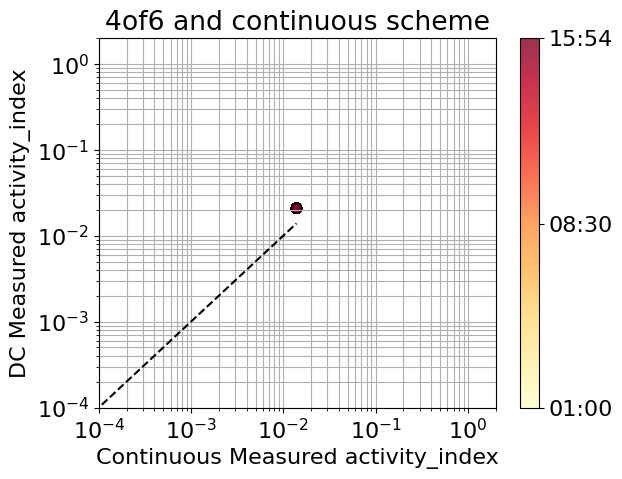

In [25]:
data_params['metric_tag'] = 'activity_index'
cont_act_ind_col2 = actvt.filter_and_prepare_metric(cont_act_ind_p2, data_params)
cont_act_ind_col2.set_index('datetime_UTC', inplace=True)

dc_act_ind_col2 = actvt.filter_and_prepare_metric(dc_act_inds_p2, data_params)
dc_act_ind_col2.set_index('datetime_UTC', inplace=True)
complot.plot_indiv_dc_control_comp_over_cycle(dc_act_ind_col2, cont_act_ind_col2, data_params)